In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/UBC-OCEAN/updated_image_ids.json
/kaggle/input/UBC-OCEAN/sample_submission.csv
/kaggle/input/UBC-OCEAN/train.csv
/kaggle/input/UBC-OCEAN/test.csv
/kaggle/input/UBC-OCEAN/test_thumbnails/41_thumbnail.png
/kaggle/input/UBC-OCEAN/train_images/14127.png
/kaggle/input/UBC-OCEAN/train_images/34649.png
/kaggle/input/UBC-OCEAN/train_images/15221.png
/kaggle/input/UBC-OCEAN/train_images/52375.png
/kaggle/input/UBC-OCEAN/train_images/17487.png
/kaggle/input/UBC-OCEAN/train_images/32112.png
/kaggle/input/UBC-OCEAN/train_images/22290.png
/kaggle/input/UBC-OCEAN/train_images/48734.png
/kaggle/input/UBC-OCEAN/train_images/39146.png
/kaggle/input/UBC-OCEAN/train_images/64950.png
/kaggle/input/UBC-OCEAN/train_images/32042.png
/kaggle/input/UBC-OCEAN/train_images/63429.png
/kaggle/input/UBC-OCEAN/train_images/13526.png
/kaggle/input/UBC-OCEAN/train_images/53859.png
/kaggle/input/UBC-OCEAN/train_images/63836.png
/kaggle/input/UBC-OCEAN/train_images/56117.png
/kaggle/input/UBC-OCEAN/train_i

**LOADING LIBRARIES**

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax" # or "tensorflow", "torch"

import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot
sns.set(style="whitegrid")

import tensorflow as tf
import keras_cv
import keras_core as keras
from keras_core import ops

Using JAX backend.


**CONFIGURATION**

In [3]:
class Config:
    is_submission = False
    
    # Reproducibility
    SEED = 42
    
    # Training
    train_csv_path = "/kaggle/input/UBC-OCEAN/train.csv"
    train_thumbnail_paths = "/kaggle/input/UBC-OCEAN/train_thumbnails"
    batch_size = 8
    learning_rate = 1e-3
    epochs = 2
    
    # Inference
    test_csv_path = "/kaggle/input/UBC-OCEAN/test.csv"
    test_thumbnail_paths = "/kaggle/input/UBC-OCEAN/test_thumbnails"

config = Config()

In [4]:
keras.utils.set_random_seed(seed=config.SEED)

**TRAINING OF DATASET**

num_rows=513
num_unique_images=513
num_unique_labels=5
unique_labels=array(['HGSC', 'LGSC', 'EC', 'CC', 'MC'], dtype=object)


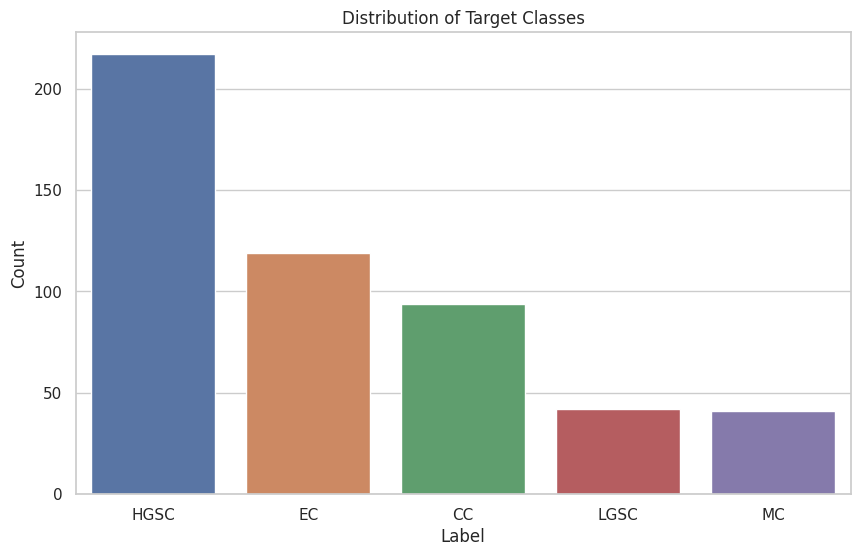

In [5]:
if not config.is_submission:
    df = pd.read_csv(config.train_csv_path)

    # Create the thumbnail df where is_tma == False
    df = df[df["is_tma"] == False]
    
    # Get basic statistics about the dataset
    num_rows = df.shape[0]
    num_unique_images = df['image_id'].nunique()
    num_unique_labels = df['label'].nunique()
    unique_labels = df['label'].unique()

    print(f"{num_rows=}")
    print(f"{num_unique_images=}")
    print(f"{num_unique_labels=}")
    print(f"{unique_labels=}")
    
    # Plot the distribution of the target classes
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
    plt.title('Distribution of Target Classes')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

**HOT ENCODING**

In [6]:
if not config.is_submission:
    # Perform one-hot encoding of the 'label' column and explicitly convert to integer type
    df_one_hot = pd.get_dummies(df["label"], prefix="label").astype(int)

    # Concatenate the original DataFrame with the one-hot encoded labels
    train_df = pd.concat([df["image_id"], df_one_hot], axis=1)

    # Get the thumbnail image paths
    train_df["image_thumbnail_path"] = train_df["image_id"].apply(lambda x: f"{config.train_thumbnail_paths}/{x}_thumbnail.png")
    
    image_thumbnail_paths = train_df["image_thumbnail_path"].values
    labels = train_df[[col for col in train_df.columns if col.startswith("label_")]].values

    label_names = [col for col in train_df.columns if col.startswith("label_")]
    name_to_id = {key.replace("label_", ""):value for value,key in enumerate(label_names)}
    id_to_name = {key:value for value, key in name_to_id.items()}
    
    # Save to dictionary to disk
    with open("id_to_name.pkl", "wb") as f:
        pickle.dump(id_to_name, f)

In [7]:
if not config.is_submission:
    class_weights = np.sum(labels) - np.sum(labels, axis=0)
    class_weights = class_weights / np.sum(class_weights) # Normalize the weights

    class_weights = {idx:weight for idx, weight in enumerate(class_weights)}

    for idx, weight in class_weights.items():
        print(f"{id_to_name[idx]}: {weight:0.2f}")

CC: 0.20
EC: 0.19
HGSC: 0.14
LGSC: 0.23
MC: 0.23


In [8]:
def read_image(path):
    file = tf.io.read_file(path)
    image = tf.io.decode_png(file, 3)
    image = tf.image.resize(image, (256, 256))
    image = tf.image.per_image_standardization(image)
    return image

In [9]:
if not config.is_submission:
    x = (
        tf.data.Dataset.from_tensor_slices(image_thumbnail_paths)
        .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    )
    y = tf.data.Dataset.from_tensor_slices(labels)

    # Zip the x and y together
    ds = tf.data.Dataset.zip((x, y))
    
    # Create the training and validation splits
    val_ds = (
        ds
        .take(50)
        .batch(config.batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    train_ds = (
        ds
        .skip(50)
        .shuffle(config.batch_size * 10)
        .batch(config.batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

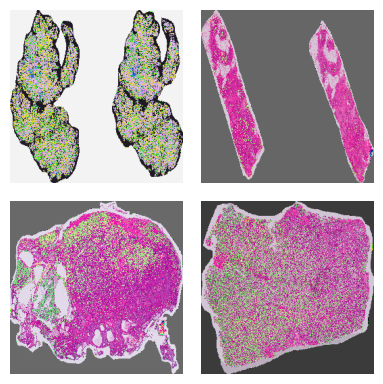

In [10]:
if not config.is_submission:
    images, labels = train_ds.take(1).get_single_element()

    keras_cv.visualization.plot_image_gallery(
        images,
        value_range=(0, 1),
        rows=2,
        cols=2,
    )

**BUILDING MODEL**

In [11]:
resnet_backbone = keras_cv.models.ResNetV2Backbone.from_preset(
    "resnet152_v2",
)
resnet_backbone.trainable = False

image_inputs = resnet_backbone.input
image_embeddings = resnet_backbone(image_inputs)
image_embeddings = keras.layers.GlobalAveragePooling2D()(image_embeddings)

x = keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(image_embeddings)
x = keras.layers.Dense(units=1024, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(units=512, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(units=256, activation="relu")(x)
outputs = keras.layers.Dense(units=5, activation="softmax")(x)

# Build the model with the Functional API
model = keras.Model(
    inputs=image_inputs,
    outputs=outputs,
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)     │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ res_net_v2_backbone             │ (None, None, None, 2048)  │ 58,331,648 │
│ (ResNetV2Backbone)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 2048)              │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 2048)              │      8,192 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1024)              │  2,098,176 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 1024)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 5)                 │      1,285 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 61,095,429 (233.06 MB)

 Trainable params: 2,759,685 (10.53 MB)

 Non-trainable params: 58,335,744 (222.53 MB)

In [12]:
if not config.is_submission:
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    history = model.fit(
        train_ds,
        epochs=config.epochs,
        validation_data=val_ds,
        class_weight=class_weights,
    )
    
    model.save_weights("ucb_ocean_checkpoint.weights.h5")

Epoch 1/2


 1/58 ━━━━━━━━━━━━━━━━━━━━ 28:51 30s/step - accuracy: 0.0000e+00 - loss: 0.2837

 2/58 ━━━━━━━━━━━━━━━━━━━━ 8:24 9s/step - accuracy: 0.0625 - loss: 0.2920      

 3/58 ━━━━━━━━━━━━━━━━━━━━ 8:13 9s/step - accuracy: 0.0972 - loss: 0.2930        

 4/58 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - accuracy: 0.1198 - loss: 0.2930

 5/58 ━━━━━━━━━━━━━━━━━━━━ 7:58 9s/step - accuracy: 0.1308 - loss: 0.2939

 6/58 ━━━━━━━━━━━━━━━━━━━━ 7:47 9s/step - accuracy: 0.1368 - loss: 0.2934

 7/58 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - accuracy: 0.1428 - loss: 0.2925

 8/58 ━━━━━━━━━━━━━━━━━━━━ 7:30 9s/step - accuracy: 0.1484 - loss: 0.2923

 9/58 ━━━━━━━━━━━━━━━━━━━━ 7:22 9s/step - accuracy: 0.1566 - loss: 0.2923

10/58 ━━━━━━━━━━━━━━━━━━━━ 7:12 9s/step - accuracy: 0.1659 - loss: 0.2923

11/58 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - accuracy: 0.1725 - loss: 0.2922

12/58 ━━━━━━━━━━━━━━━━━━━━ 6:55 9s/step - accuracy: 0.1790 - loss: 0.2921

13/58 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - accuracy: 0.1859 - loss: 0.2916

**INFERENCE**

In [ ]:
if config.is_submission:
    df = pd.read_csv(config.test_csv_path)
    df["image_path"] = df["image_id"].apply(lambda x: f"{config.test_thumbnail_paths}/{x}_thumbnail.png")
    
    # Load the model weights
    model.load_weights("/kaggle/input/kerascv-train-and-infer-on-thumbnails/ucb_ocean_checkpoint.weights.h5")
    
    # Load the id to name dictionary
    with open("/kaggle/input/kerascv-train-and-infer-on-thumbnails/id_to_name.pkl", "rb") as f:
        id_to_name = pickle.load(f)

In [ ]:
if config.is_submission:
    predicted_labels = []

    for index, row in df.iterrows():
        # Get the image path
        image_path = row["image_path"]

        # Get the image
        image = read_image(image_path)[None, ...]

        # Predict the label
        logits = model.predict(image)
        pred = ops.argmax(logits, axis=-1).tolist()[0]

        # Map the pred to the name
        label = id_to_name[pred]

        predicted_labels.append(label)

    # Add the predicted labels to the csv
    df["label"] = predicted_labels

In [ ]:
if config.is_submission:
    # Create the submission
    submission_df = df[["image_id", "label"]]
    submission_df.to_csv("submission.csv", index=False)